# 4_7DS_Sensitivity
# Estimate 7DS sensitivity limits

## Author
- Yujin Yang (KASI SPHEREx Team)

## Goal
- Estimate 7DS survey depth
- Understand how 7DS detection limits are determined
- Build your own ETC for ground-based observation

<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
    The numbers in this notebook is for approximation only! Consult the 7DS project scientist or manager!
    </span>    
</div>

## <span style='color:DarkSlateBlue'> Setting for this notebook </span>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy import sqrt, exp, log10, pi
from scipy.integrate import trapezoid

from astropy import units as u
from astropy import constants as const
from astropy.table import Table, QTable, join, vstack

mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["axes.labelsize"] = 15

In [3]:
# Constants
h = 6.626e-27 # erg/Hz
c = 3e10      # cm/s 

rad2arcsec = (180/pi*3600) # 206265 arcsec
arcsec2rad = 1/rad2arcsec

## <span style='color:DarkSlateBlue'> Helper functions </span>

In [4]:
from spherex_helper import tophat_trans
from spherex_helper import plot_SPHEREx_limit

## <span style='color:DarkSlateBlue'> 1. 7DT/7DS Parameters - telescope, detectors, LVFs, efficiencies </span>

### LVF / Filter Information

(0.0, 1.2)

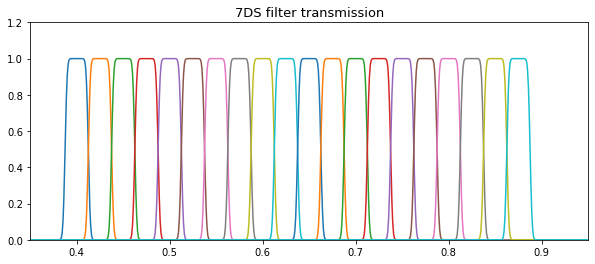

In [51]:
plt.figure(figsize=(10, 4))
plt.title(f'7DS filter transmission')

fwhm = 250 # [Angstrom] FWHM

lambda_7ds = np.arange(4000., 9000., 250)
wave_lvf = np.linspace(0.1, 1.0, 1001)

# Create filter_set definition
filter_set = {'cwl': lambda_7ds,
              'wave': wave_lvf}

for ii, wl_cen in enumerate(lambda_7ds):
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    filter_set.update({f'{ii}': resp_lvf})
    plt.plot(wave_lvf, resp_lvf)
    
plt.xlim(0.35, 0.95)
plt.ylim(0.00, 1.20)

In [52]:
filter_set.keys()

dict_keys(['cwl', 'wave', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'])

In [53]:
filter_set

{'cwl': array([4000., 4250., 4500., 4750., 5000., 5250., 5500., 5750., 6000.,
        6250., 6500., 6750., 7000., 7250., 7500., 7750., 8000., 8250.,
        8500., 8750.]),
 'wave': array([0.1   , 0.1009, 0.1018, ..., 0.9982, 0.9991, 1.    ]),
 '0': array([0., 0., 0., ..., 0., 0., 0.]),
 '1': array([0., 0., 0., ..., 0., 0., 0.]),
 '2': array([0., 0., 0., ..., 0., 0., 0.]),
 '3': array([0., 0., 0., ..., 0., 0., 0.]),
 '4': array([0., 0., 0., ..., 0., 0., 0.]),
 '5': array([0., 0., 0., ..., 0., 0., 0.]),
 '6': array([0., 0., 0., ..., 0., 0., 0.]),
 '7': array([0., 0., 0., ..., 0., 0., 0.]),
 '8': array([0., 0., 0., ..., 0., 0., 0.]),
 '9': array([0., 0., 0., ..., 0., 0., 0.]),
 '10': array([0., 0., 0., ..., 0., 0., 0.]),
 '11': array([0., 0., 0., ..., 0., 0., 0.]),
 '12': array([0., 0., 0., ..., 0., 0., 0.]),
 '13': array([0., 0., 0., ..., 0., 0., 0.]),
 '14': array([0., 0., 0., ..., 0., 0., 0.]),
 '15': array([0., 0., 0., ..., 0., 0., 0.]),
 '16': array([0., 0., 0., ..., 0., 0., 0.]),
 

Text(0, 0.5, 'Normalized Transmission')

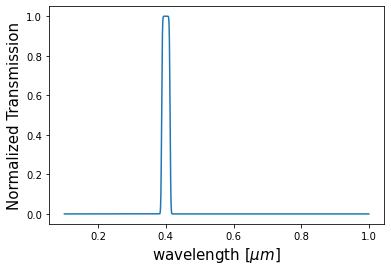

In [54]:
plt.plot(filter_set['wave'], filter_set['0'])
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Normalized Transmission')

### Telescope
- Twenty 0.5m telescopes, f/3
- Planewave DR50 model (2021.12.02)

In [55]:
D = 50.5               # effetive diameter [cm]
D_obscuration = 29.8   # Central Obscuration (diameter)
EFL = 1537.3           # [mm]

Deff = sqrt(D**2 - D_obscuration**2)

### Detectors (nominal)
- We don't know the detail of the detector (as of 2022/04/29, it is not determined)
- Let's use typical parameters 
- Assume quantum efficiency (QE) of the Gemini GMOS as an example
- `C3-61000 PRO`

Text(0.5, 1.0, 'Gemini GMOS-N Hamamatsu CCD')

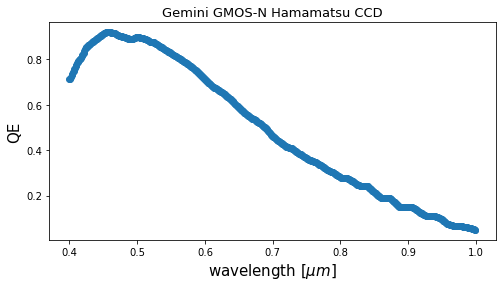

In [82]:
array = 'CMOS'       # detector array type
dQ_RN = 3.           # [e], readout noise 
I_dark = 0.01        # [e/s], dark current
pixel_size = 3.76    # [um], "pitch"
theta_pixel = 0.517  # [arcsec], pixel scale 
nxpix, nypix = 9576, 6388  # [pixels], detector format, approx. 9k x 6k

# QE table of Gemini GMOS-N Hamamatsu CCD
T_qe = Table.read('../data/IMX455_QE.csv', 
                  format='ascii')
T_qe['wavelength[um]'] = T_qe['wavelength[um]'].astype(float)
T_qe['wavelength[um]'].unit = u.um
T_qe['wavelength[um]'].format = '8.4f'

plt.figure(figsize=(8,4))
plt.plot(T_qe['wavelength[um]'], T_qe['QE'], 'o-')
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('QE')
plt.title('Gemini GMOS-N Hamamatsu CCD')

### Efficiencies
- For coatings and camera optics, we can implement wavelength dependent efficiencies

In [83]:
eff_mirrors = (0.92)**2  # Aluminium coating, 2 mirrors
eff_optics = 0.95        # Camera optics 
eff_LVF = 0.90           # LVF peak transmission (filter top transmission)
eff_fpa = 0.80           # Detector Quantum Efficiency (QE), nominal value

lambda_mid = 0.6
eff_fpa = np.interp(lambda_mid, T_qe['wavelength[um]']/1000, T_qe['QE'])

eff_opt   = eff_mirrors * eff_optics * eff_LVF
eff_total = eff_opt * eff_fpa

eff_fpa, eff_opt, eff_total

(0.0488, 0.723672, 0.0353151936)

## <span style='color:DarkSlateBlue'> 2. System Response Function  </span>

### Atmospheric transmission
- Site dependent!
- Model for Paranal site (VLT)
    - https://www.eso.org/sci/software/pipelines/skytools/skycalc
    - Run web-based calculator with 
        - `airmass = 1.3`
        - `PWV` = 2.5mm (very good, not critical in the optical)
        - `$\lambda_{min}$ =  300nm`
        - `$\lambda_{min}$ = 5000nm`
        - `Logarithmic binning` λ/Δλ = 20000 (default; decrease to save time and space)
        - Check `Calculate Broad-Band`

Text(0, 0.5, 'Transmission')

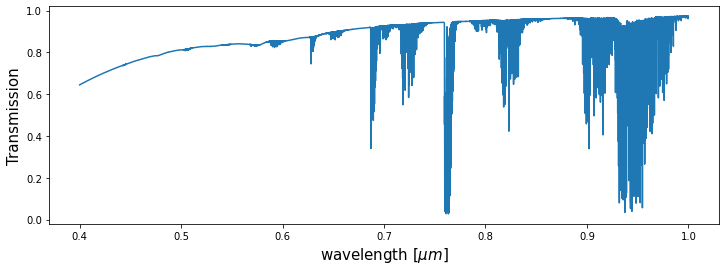

In [84]:
s = Table.read('../data/transmission_atm_45')

plt.figure(figsize=(12,4))
plt.plot(s['lam']/1e3, s['trans'])
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
# plt.xlim(0.3, 2)

### Smooth transmission to match filter's R

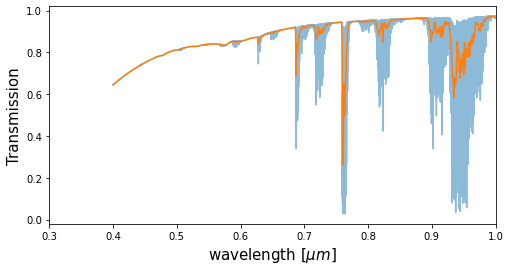

In [85]:
plt.figure(figsize=(8,4))
plt.plot(s['lam']/1e3, s['trans'], alpha=0.5)
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
plt.xlim(0,3)
plt.xlim(0.3,1)

from scipy.ndimage import gaussian_filter
trans_smooth = gaussian_filter(s['trans'], 10)
plt.plot(s['lam']/1e3, trans_smooth)

### Build system response including all components
- `response` dictionary (you can create python `class`)
- `_lvf`: filter
- `_sys`: system

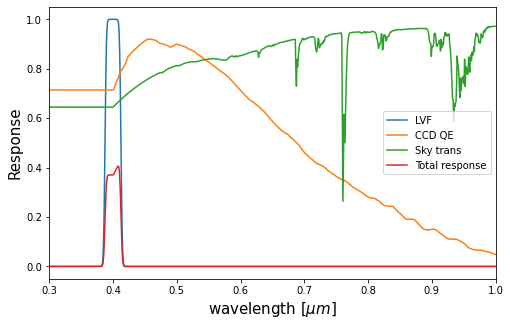

In [86]:
response = {'cwl': lambda_7ds,
            'wave': wave_lvf}

_ = plt.figure(figsize=(8,5))
for ii, cwl in enumerate(filter_set['cwl']):
    
    wave_lvf = filter_set['wave']
    resp_lvf = filter_set[f'{ii}']
    
    resp_sys = resp_lvf.copy()
    intp_qe = np.interp(wave_lvf, T_qe['wavelength[um]'], T_qe['QE'])
    intp_trans = np.interp(wave_lvf, s['lam']*1e-3, trans_smooth)
    
    resp_sys = resp_sys * intp_qe * intp_trans 
    resp_sys *= eff_mirrors * eff_optics
    
    response.update({f'{ii}': resp_sys})
    
    if ii == 0:
        plt.plot(wave_lvf, resp_lvf, label='LVF')
        plt.plot(wave_lvf, intp_qe, label='CCD QE')
        plt.plot(wave_lvf, intp_trans, label='Sky trans')
        plt.plot(wave_lvf, resp_sys, label='Total response')
    
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Response')
plt.xlim(0.3,1)
plt.legend()

(0.35, 0.85)

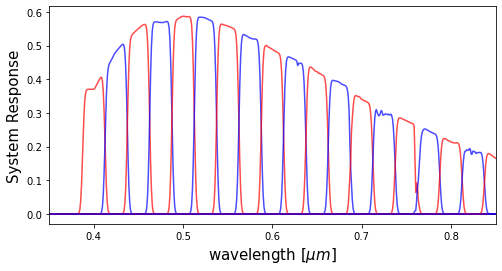

In [87]:
plt.figure(figsize=(8,4))

for ii, cwl in enumerate(response['cwl']):
    wave_lvf = response['wave']
    resp_sys = response[f'{ii}']
    
    if not ii % 2:
        plt.plot(wave_lvf, resp_sys, color='r', alpha=0.7)
    else:
        plt.plot(wave_lvf, resp_sys, color='b', alpha=0.7)
    
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('System Response')
plt.xlim(0.35,0.85)

## <span style='color:DarkSlateBlue'> 3. Survey Plan & Design </span>
- **Site**
    - Chile, El Sauce Observatory
- **Surveys**
    - Reference (RIS): 20,000 deg^2
    - Wide-Field (Wide)
    - Intensive Monitoring Survey (IMS)
- **Details**
    - Moon phases
    - Weather loss

In [88]:
survey_area_per_night = 113.  # [deg^2]
hrs_per_night = 9.            # hours per night

FOV_per_pointing = nxpix*nypix * theta_pixel**2 / 3600**2
T_exposure = hrs_per_night / (survey_area_per_night/FOV_per_pointing) * 3600 / 2

print(f'FOV           = {FOV_per_pointing:10.3g} deg^2')
print(f'Exposure time = {T_exposure:10.3g} sec')

FOV           =       1.26 deg^2
Exposure time =        181 sec


In [89]:
fwhm_seeing = 1.5     # [arcsec]
FWHM0 = fwhm_seeing   # analysis aperture size
Tsamp = 180.          # individual exposure time [sec], 3min

# How many pixels does a point source occupy?
# Effective number of pixels for a Gaussian PSF with FWHM0
Npix_ptsrc = pi*(FWHM0/theta_pixel)**2
Npix_ptsrc

26.4454708969581

### Number of exposures per field
Need to determine Nexp for each survey depending on the science requirements and funds.

In [90]:
Nexp = 1

## <span style='color:DarkSlateBlue'> 4. Noise Sources </span>

### Readout noise per integration

In [91]:
dQ_RN

3.0

### Sky background: atmosphere
- Use sky model from ESO (`skytable.fits`)
- Ignore Zodi, telescope, instruments
- TODO: Scale or update the model for the actual site

In [92]:
s = Table.read('../data/transmission_atm_45')
s

lam,flux,dflux1,dflux2,trans,dtrans1,dtrans2,flux_sml,flux_ssl,flux_zl,flux_tie,flux_tme,flux_ael,flux_arc,trans_ma,trans_o3,trans_rs,trans_ms
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
400.0,738.463470228454,29.89683340062927,29.89683340062927,0.6445022744054059,0.0,0.0,622.5051651354106,13.24508980194679,30.62778643194619,0.0,0.0,0.0,72.08542885915041,0.999922259425402,1.0,0.6875481409882985,0.9374650935008962
400.02000050000834,813.4242443697962,42.5877998059506,42.5877998059506,0.6445630520237224,0.0,0.0,622.6755595971334,13.246379446886387,30.63713935309899,0.0,0.0,74.77574351829902,72.08942245437838,0.9999342239579931,1.0,0.6876016867265476,0.9374692704547409
400.0400020000667,738.8240088854756,29.898944760740125,29.898944760740125,0.6446155074966489,0.0,0.0,622.8379062353465,13.247518096206969,30.646098518760805,0.0,0.0,0.0,72.09248603516129,0.9999332871639685,1.0,0.6876552252885753,0.9374734471389946
400.06000450022503,881.7414319124885,65.1601050035445,65.1601050035445,0.6446685012234462,0.0,0.0,623.0007731361868,13.248666697772224,30.655085005963294,0.0,0.0,142.74129647206553,72.09561060050049,0.9999331954275698,1.0,0.687708756674521,0.9374776235536733
400.0800080005334,739.176741020379,29.90074051507123,29.90074051507123,0.6447219111615832,0.0,0.0,623.1640424634597,13.249823034796782,30.664093026738993,0.0,0.0,0.0,72.09878249538347,0.9999337592578635,1.0,0.6877622808845251,0.9374817996987931
400.10001250104176,739.353669170794,29.901661449966017,29.901661449966017,0.6447756005391913,0.0,0.0,623.3275820405592,13.250984622892664,30.673116087525177,0.0,0.0,0.0,72.10198641981692,0.9999347663836785,1.0,0.6878157979187287,0.9374859755743704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999.6593261683576,738.0483629958633,322.9404096717202,322.9404096717202,0.9725946889589322,0.0,0.0,135.43210290723962,2.637649265027589,41.136837739644854,0.0,0.0,0.0,558.8417730839512,0.9997408912146599,0.9997171731906431,0.9910384140274926,0.9819215615808712
999.7093103842609,737.9133562888181,322.9116268397129,322.9116268397129,0.9723702590339135,0.0,0.0,135.3857426488501,2.6370141941319085,41.12504532711924,0.0,0.0,0.0,558.7655541187169,0.9995071217198042,0.9997171731906431,0.9910402159450946,0.9819227976070544


In [93]:
s.meta

OrderedDict([('comments',
              ['',
               'SkyCalc version: 2.0.9',
               '',
               'ESO Sky Model www.eso.org/observing/etc/skycalc/skycalc.htm',
               'Documentation www.eso.org/observing/etc/doc/skycalc/helpskycalc.html',
               '          and www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html',
               'References: Noll et al. (2012, A&A 543, A92)',
               '        and Jones et al. (2013, A&A 560, A91)',
               '',
               'column lam:     Vacuum wavelength in nm',
               'column flux:    sky emission radiance flux in ph/s/m2/micron/arcsec2',
               'column trans:   sky transmission',
               '',
               'Individual emission components in ph/s/m2/micron/arcsec2:',
               'column flux_sml:    scattered moonlight',
               'column flux_ssl:    scattered starlight',
               'column flux_zl:     zodiacal light',
               'column flux_tie:  

### Sky emission in various units
- photon rate   (ph/s/m$^2$/micron/arcsec$^2$)
- $f_\lambda$   (erg/s/cm$^2$/A/arcsec$^2$)
- $f_\nu$       (erg/s/cm$^2$/Hz/arcsec$^2$)


In [94]:
wl_nm = s['lam']          # nm
wl_um = wl_nm / 1e3       # micron
wl_cm = wl_um / 1e4       # cm
wl_am = wl_angstrom = wl_nm * 10  # angstrom
nu = 3e18 / wl_angstrom   # Hz

I_lambda = s['flux']      # [ph/s/m2/micron/arcsec2] photon reate
f_lambda = I_lambda * (h*c/wl_cm) / (1e2**2) / (1e4)  # erg/s/cm2/A

Text(0, 0.5, '$SB_\\lambda$ [$ph/s/m^2/\\mu m/arcsec^2$]')

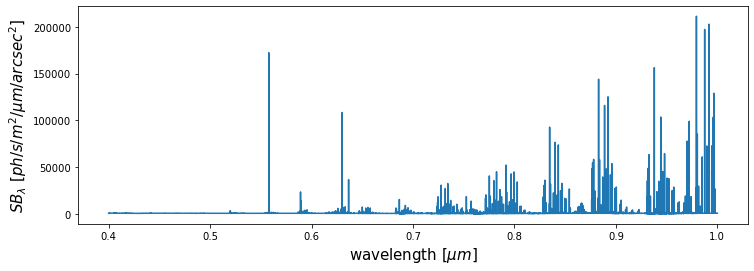

In [95]:
plt.figure(figsize=(12,4))
plt.plot(wl_um, I_lambda)
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('$SB_\lambda$ [$ph/s/m^2/\mu m/arcsec^2$]')

Text(0, 0.5, '$SB_\\lambda$ [$erg/s/cm^2/\\AA/arcsec^2$]')

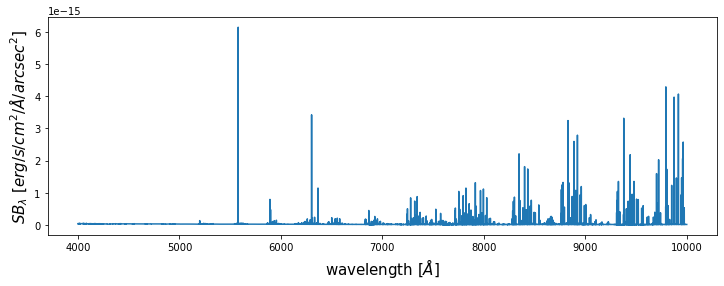

In [96]:
o = (wl_angstrom > 3000) & (wl_angstrom < 10000)

plt.figure(figsize=(12,4))
plt.plot(wl_am[o], f_lambda[o])
plt.xlabel('wavelength [$\AA$]')
plt.ylabel('$SB_\lambda$ [$erg/s/cm^2/\AA/arcsec^2$]')

Text(0, 0.5, '$SB_\\nu$ [$\\mu Jy/arcsec^2$]')

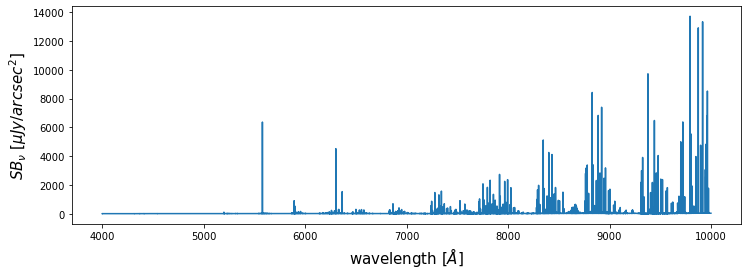

In [97]:
f_nu = f_lambda * wl_angstrom * (wl_cm/c) / (1e-23 * 1e-6)  # micro Jansky

o = (wl_angstrom > 3000) & (wl_angstrom < 10000)

plt.figure(figsize=(12,4))
plt.plot(wl_angstrom[o], f_nu[o])
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'$SB_\nu$ [$\mu Jy/arcsec^2$]')

In [98]:
f_nu

19.57223581493495
21.560074149534913
19.583749808566015
23.37318062556729
19.595058963921858
19.60072921753536
19.60638906996207
19.61125121967553
19.617631759728795
...
48.74906435050604


(24.0, 14.0)

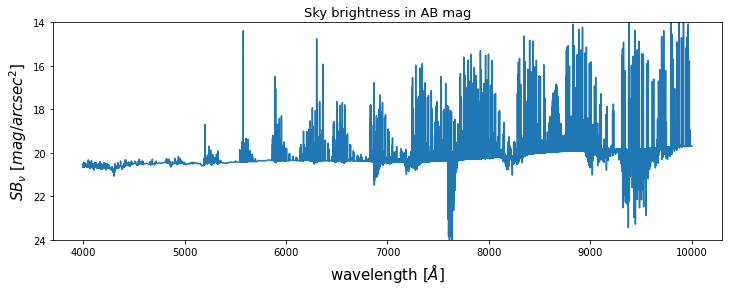

In [99]:
plt.figure(figsize=(12,4))
plt.plot(wl_angstrom[o], -2.5*np.log10(f_nu[o]*1e-6*1e-23)-48.60)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'$SB_\nu$ [$mag/arcsec^2$]')
plt.title('Sky brightness in AB mag')
plt.ylim(24,14)

In [100]:
# check
# f_lambda / (h*nu)  # erg/s/cm2/A
# f_lambda / (h*nu) / (1e-2**2) / (1e-4) # erg/s/m2/um
# plt.plot(wl_um,f_lambda / (h*nu) / (1e-2**2) / (1e-4))

### Zodi
- Not significant contribution compared to atmosphere

## <span style='color:DarkSlateBlue'> 5. Sensitivity Estimates </span>

### Update the synthetic photometry function to return `photon rate`

In [101]:
def synth_phot(wave, flux, wave_lvf, resp_lvf, tol=1e-3, return_photonrate = False):
    """
    Quick synthetic photometry routine.

    Parameters
    ----------
    wave : `numpy.ndarray`
        wavelength of input spectrum.
    flux : `numpy.ndarray`
        flux density of input spectrum in f_nu unit
        if `return_countrate` = True, erg/s/cm2/Hz is assumed
    wave_lvf : `numpy.ndarray`
        wavelength of the response function
    resp_lvf : `numpy.ndarray`
        response function. assume that this is a QE.
    tol : float, optional
        Consider only wavelength range above this tolerence (peak * tol).
        The default is 1e-3.

    Returns
    -------
    synthethic flux density in the input unit
        if return_photonrate = True, photon rates [ph/s/cm2]

    """
    index_filt, = np.where(resp_lvf > resp_lvf.max()*tol)

    index_flux, = np.where(np.logical_and( wave > wave_lvf[index_filt].min(), 
                                           wave < wave_lvf[index_filt].max() ))

    wave_resamp = np.concatenate( (wave[index_flux], wave_lvf[index_filt]) )
    wave_resamp.sort()
    wave_resamp = np.unique(wave_resamp)
    flux_resamp = np.interp(wave_resamp, wave, flux)
    resp_resamp = np.interp(wave_resamp, wave_lvf, resp_lvf)

    if return_photonrate:
        h_planck = 6.626e-27 # erg/Hz
        return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) / h_planck
        
    return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) \
         / trapezoid(resp_resamp / wave_resamp, wave_resamp)

Text(0, 0.5, 'Response')

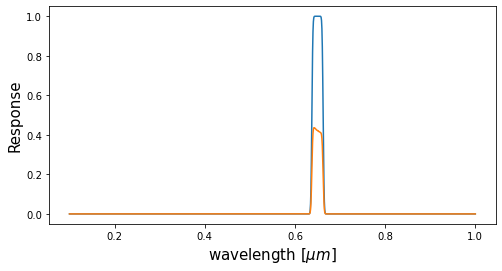

In [102]:
# Choose a band
band_key = '10'
wave_sys = response['wave']
resp_sys = response[band_key]
resp_lvf = filter_set[band_key]

lambda_mid = response['cwl'][10]

plt.figure(figsize=(8,4))
plt.plot(wave_lvf, resp_lvf)
plt.plot(wave_lvf, resp_sys)

plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'Response')

### Extended source or surface brightness [one pixel]

In [103]:
# photon_rate: ph/s/cm2/arcsec2
photon_rate = synth_phot(wl_um, f_nu*(1e-23*1e-6), wave_sys, resp_sys, return_photonrate=True)
print(f'{photon_rate:10.3g} ph/s/cm2/arcsec2')

# Sky surface brightness 
SB_sky = synth_phot(wl_um, f_nu*(1e-23*1e-6), wave_lvf, resp_lvf)
SB_sky_abmag = -2.5*log10(SB_sky) - 48.60
print(f'{SB_sky:10.3g} erg/s/cm2/Hz/arcsec2')
print(f'{SB_sky_abmag:10.3g} mag/arcsec2')

  0.000719 ph/s/cm2/arcsec2
  2.92e-28 erg/s/cm2/Hz/arcsec2
      20.2 mag/arcsec2


In [104]:
# Sky background rate
# I_photo = photo-current rate    [e/s]
# Q_photo = total counts          [e]

# Photo-current rate
I_photo = photon_rate * (pi/4*Deff**2) * (theta_pixel**2)
print(f'{I_photo:10.3g} e/s')

# Noise in count per obs [e]. 
Q_photo = (I_photo+I_dark)*Tsamp
dQ_photo = np.sqrt(Q_photo)
print(f'{Q_photo:10.3g} e')

# Noise in count rate [e/s]
# Readnoise (indistinguishable from signal) is added 
dI_photo = np.sqrt(dQ_photo**2 + dQ_RN**2)/Tsamp

# Noise in SB_sky
dSB_sky = (dI_photo/I_photo)*SB_sky
mag_sky = -2.5*log10(5*dSB_sky) - 48.60
print(f'{mag_sky:10.3g} mag/arcsec2')

     0.251 e/s
        47 e
      20.4 mag/arcsec2


### Point source

In [105]:
dFnu = sqrt(Npix_ptsrc) * dSB_sky*(theta_pixel)**2
mag_pts = -2.5*log10(5*dFnu) - 48.60
print(f'{mag_pts:10.3g} mag')

      20.1 mag


In [106]:
print(f"wavelength_mid = {lambda_mid:12.3f} um")
print(f"SB_sky         = {SB_sky:12.5g} erg/s/cm2/Hz/arcsec2")
print(f"I_photo        = {I_photo:12.5g} e-/s")
print(f"dI_photo       = {dI_photo:12.5g} e-/s")
print(f"Q_photo        = {Q_photo:12.5g} e-")
print(f"dQ_photo       = {dQ_photo:12.5g} e-")
print(f"dSB_sky        = {dSB_sky:12.5g} erg/s/cm2/Hz/arcsec2")
print(f"mag_sky (5sig) = {mag_sky:12.5g} mag/arcsec2")
print(f"mag_pts (5sig) = {mag_pts:12.5g} mag")

wavelength_mid =     6500.000 um
SB_sky         =    2.924e-28 erg/s/cm2/Hz/arcsec2
I_photo        =       0.2509 e-/s
dI_photo       =      0.04156 e-/s
Q_photo        =       46.961 e-
dQ_photo       =       6.8528 e-
dSB_sky        =   4.8434e-29 erg/s/cm2/Hz/arcsec2
mag_sky (5sig) =        20.44 mag/arcsec2
mag_pts (5sig) =       20.094 mag


### In ETC style
- SN as a function of Texp
- SN as a function of input flux

In [107]:
def pointsrc_signal2noise(mag_src, Tsamp):
    """
    Calculate SN for a point source
    
    Input
        mag_src: AB mag of the source, scalar
        Tsamp: individual exposure time [sec], can be scalar or array

    WARNING: !!! ALL VARIABLES ARE GLOBALLY DECLARED !!!
    """
    # mag_src = 19.7
    Naper = Npix_ptsrc 

    # mag_src = 20.1 - 2.5*np.log10(theta_pixel**2)
    # Naper = 1

    f_nu_src = f_nu*0 + 10**(-0.4*(mag_src + 48.6))  # erg/s/cm2/Hz
    f_nu_sky = f_nu*(1e-23*1e-6)                     # erg/s/cm2/Hz/arcsec2

    photon_rate_src = synth_phot(wl_um, f_nu_src, wave_sys, resp_sys, return_photonrate=True)  # ph/s/cm2
    photon_rate_sky = synth_phot(wl_um, f_nu_sky, wave_sys, resp_sys, return_photonrate=True)  # ph/s/cm2/arcsec2

    I_photo_src = photon_rate_src * (pi/4*Deff**2)                     # [e/s] per aperture (no aperture loss)
    I_photo_sky = photon_rate_sky * (pi/4*Deff**2) * (theta_pixel**2)  # [e/s] per pixel 

    Q_photo_src = I_photo_src * Tsamp
    Q_photo_sky = I_photo_sky * Tsamp
    Q_photo_dark = I_dark * Tsamp

    SN = Q_photo_src / np.sqrt(Q_photo_src + Naper*Q_photo_sky + Naper*Q_photo_dark + Naper*dQ_RN**2)

    return SN

In [108]:
resp_sys

array([0., 0., 0., ..., 0., 0., 0.])

In [111]:
# Test
pointsrc_signal2noise(19.74, 180)

6.377164486039236

(0.002, 46.29844584946905)

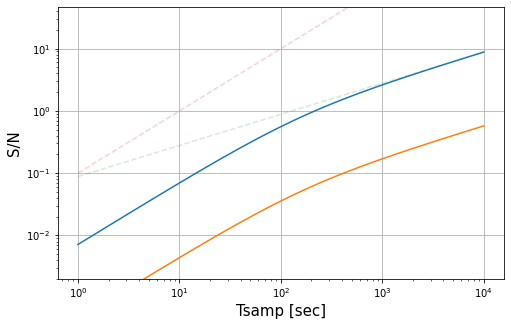

In [38]:
t_vec = np.logspace(0, 4, 100)

plt.figure(figsize=(8,5))

plt.plot(t_vec, pointsrc_signal2noise(19.7, t_vec))
plt.plot(t_vec, pointsrc_signal2noise(22.7, t_vec))
_, ymax = plt.gca().get_ylim()


plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Tsamp [sec]')
plt.ylabel('S/N')

sn_sqrt   = np.sqrt(t_vec/t_vec.max()) * pointsrc_signal2noise(19.7, t_vec.max())
sn_linear = t_vec/t_vec.max() * pointsrc_signal2noise(19.7, t_vec.min())

plt.plot(t_vec, sn_sqrt, alpha=0.2, linestyle='--')
plt.plot(t_vec, t_vec/10, alpha=0.2, linestyle='--')
plt.ylim(2e-3, ymax*5)

Text(0, 0.5, 'S/N')

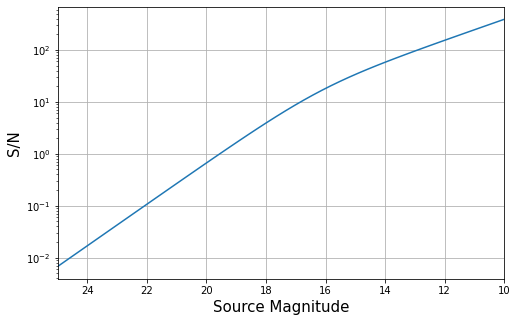

In [39]:
t_vec = 180.
m_vec = np.linspace(25, 10)

sn_vec = [pointsrc_signal2noise(m, t_vec) for m in m_vec]

plt.figure(figsize=(8,5))
plt.plot(m_vec, sn_vec)
plt.yscale('log')
plt.grid()
plt.xlim(m_vec.max(), m_vec.min())
plt.xlabel('Source Magnitude')
plt.ylabel('S/N')

In [117]:
# Check 5sigma detection limit
np.interp(5, sn_vec, m_vec)

17.71559004299342

### For all 7DS bands
- from 7DS spec sheet:
    - 20.2 AB mag at 425nm
    - 19.8 AB mag at 675nm 
    - 18.9 AB mag at 825nm (5-sigma, pt source, 3min)

In [128]:
unit_SB  = u.nW/(u.m)**2/u.sr
unit_cntrate = u.electron / u.s

T_sens = (Table( 
             names=('band', 'wavelength', 'I_photo_sky', 'mag_sky', 'mag_pts', 'SN', 'SN_dI'),
             dtype=(np.int16,float,float,float,float,float,float,) )
         )
for key in T_sens.colnames:
    T_sens[key].info.format = '.4g'

In [132]:
for ii, cwl in enumerate(response['cwl']):
    wave_sys = response['wave']
    resp_sys = response[f'{ii}']
    resp_lvf = filter_set[f'{ii}']
    
    # photon rate
    photon_rate = synth_phot(wl_um, f_nu*(1e-23*1e-6), wave_sys, resp_sys, return_photonrate=True)

    # SB
    SB_sky = synth_phot(wl_um, f_nu*(1e-23*1e-6), wave_lvf, resp_lvf)

    # photo-current or count rate
    I_photo = photon_rate * (pi/4*D**2) * (theta_pixel**2)

    # noise in count per obs [e]. 
    Q_photo = (I_photo+I_dark)*Tsamp
    dQ_photo = np.sqrt(Q_photo)

    # noise in count rate [e/s]
    # read-noise (indistinguishable from signal) should be added 
    dI_photo = np.sqrt(dQ_photo**2 + dQ_RN**2)/Tsamp
    SN_dI = I_photo/dI_photo
    
    # surface brightness limit [one pixel]
    dSB_sky = (dI_photo/I_photo)*SB_sky
    mag_sky = -2.5*log10(5*dSB_sky) - 48.60

    # point source limit
    dFnu = sqrt(Npix_ptsrc) * dSB_sky*(theta_pixel)**2
    mag_pts = -2.5*log10(5*dFnu) - 48.60
    
    def pointsrc_signal2noise(mag_src, Tsamp):
        """
        Calculate SN for a point source

        Input
            mag_src: AB mag of the source, scalar
            Tsamp: individual exposure time [sec], can be scalar or array

        WARNING: !!! ALL VARIABLES ARE GLOBALLY DECLARED !!!
        """
        # mag_src = 19.7
        Naper = Npix_ptsrc

        # mag_src = 20.1 - 2.5*np.log10(theta_pixel**2)
        # Naper = 1

        f_nu_src = f_nu_sky_ujy*0 + 10**(-0.4*(mag_src + 48.6))                   # erg/s/cm2/Hz
        f_nu_sky = f_nu_sky_ujy*(1e-23*1e-6)                     # erg/s/cm2/Hz/arcsec2

        photon_rate_src = synth_phot(wl_aa*1e-4, f_nu_src, wave_sys, resp_sys, return_photonrate=True)  # ph/s/cm2
        photon_rate_sky = synth_phot(wl_aa*1e-4, f_nu_sky, wave_sys, resp_sys, return_photonrate=True)  # ph/s/cm2/arcsec2

        I_photo_src = photon_rate_src * (np.pi/4*D_eff**2)                     # [e/s] per aperture (no aperture loss)
        I_photo_sky = photon_rate_sky * (np.pi/4*D_eff**2) * (theta_pixel**2)  # [e/s] per pixel 

        Q_photo_src = I_photo_src * Tsamp
        Q_photo_sky = I_photo_sky * Tsamp
        Q_photo_dark = I_dark * Tsamp

        SN = Q_photo_src / np.sqrt(Q_photo_src + Naper*Q_photo_sky + Naper*Q_photo_dark + Naper*dQ_RN**2)

        return SN
    SN = pointsrc_signal2noise(mag_pts, Tsamp)

    # Add data to the table
    T_sens.add_row([ii, cwl, I_photo, mag_sky, mag_pts, SN, SN_dI]) 

# Put units
T_sens['wavelength'].unit = u.um
T_sens['I_photo_sky'].unit = unit_cntrate
T_sens['mag_sky'].unit = u.mag
T_sens['mag_pts'].unit = u.mag    

NameError: name 'f_nu_sky_ujy' is not defined

In [120]:
T_sens

band,wavelength,I_photo_sky,mag_sky,mag_pts
,um,electron / s,mag,mag
int16,float64,float64,float64,float64
0,4000,0.3874,21.13,20.78
1,4250,0.4281,21.25,20.9
2,4500,0.5445,21.22,20.88
3,4750,0.5612,21.19,20.85
4,5000,0.5443,21.18,20.83
5,5250,0.5254,21.13,20.79
...,...,...,...,...
14,7500,0.2588,20.24,19.9


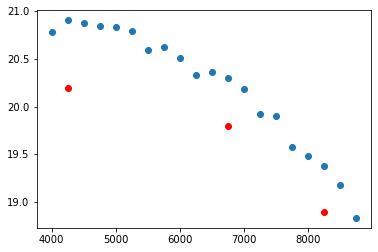

In [127]:
plt.scatter(T_sens['wavelength'], T_sens['mag_pts'])
plt.plot(np.array([4250, 6750, 8250]), [20.2, 19.8, 18.9], 'o', c = 'r')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Public-products/Point_Source_Sensitivity_v28_base_cbe.txt'

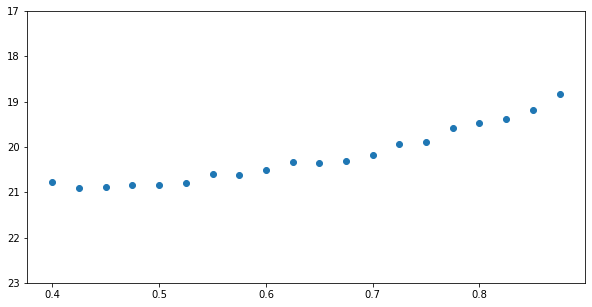

In [122]:
fig, ax = plt.subplots(1, figsize=(10,5))

ax.plot(T_sens['wavelength']/1e4, T_sens['mag_pts'], 'o')
ax.set_ylim(23,17)

CBE = Table.read('data/Public-products/Point_Source_Sensitivity_v28_base_cbe.txt', format='ascii.no_header')
lambda_um, mag_5sig = CBE['col1'], CBE['col2']
plot_SPHEREx_limit(lambda_um, mag_5sig, ax=ax)

plt.xlabel(r'wavelength [$\mu m$]')
plt.ylabel(r'Point source limits (5$\sigma$)')

plt.plot(np.array([425, 675, 825])/1000, [20.2, 19.8, 18.9], 'o')

# ax.set_xscale('log')
# ax.set_ylim(24.5,14.5)

# <span style='color:DarkSlateBlue'> Exercises </span>

## 4.1 Calculate the point source sensitivity assuming that the 7DT is located in Paranal or LCO sites (median seeing = 0.8arcsec)
- Translate potential improvement into the upgrade of telescope aperture. $D_{\rm equiv}$ = ?

## 4.2 Repeat for the Wide & IMS surveys